# Лабораторная работа №7. Рекуррентные нейронные сети для анализа текста

**Данные:**

Набор данных для предсказания оценок для отзывов, собранных с сайта imdb.com, который состоит из 50,000 отзывов в виде текстовых файлов. Отзывы разделены на положительные (25,000) и отрицательные (25,000). Данные предварительно токенизированы по принципу “мешка слов”, индексы слов можно взять из словаря (imdb.vocab). Обучающая выборка включает в себя 12,500 положительных и 12,500 отрицательных отзывов, контрольная выборка также содержит 12,500 положительных и 12,500 отрицательных отзывов, а также. Данные можно скачать по ссылке https://ai.stanford.edu/~amaas/data/sentiment/

In [0]:
# !pip install tensorflow==2.2rc0

In [0]:
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import re
import pdb
import pathlib
import re
import zipfile
import tensorflow_datasets as tfds

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print(
        '\n\nThis error most likely means that this notebook is not '
        'configured to use a GPU.  Change this in Notebook Settings via the '
        'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
    raise SystemError('GPU device not found')

In [0]:
DRIVE_DIR = '/content/drive/My Drive/Colab Notebooks/7/'

Скачиваем данные

In [9]:
aclImdb_v1_file_path = tf.keras.utils.get_file("aclImdb_v1", 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz', cache_dir='/content', untar=True, extract=True)

84131840/84125825 [==============================] - 2s 0us/step


#### model

In [0]:
import random
import datetime

class Model:
    EPOCH_COUNT = 10
    
    def __init__(self, layers=[], model=None, optimizer=None, loss='sparse_categorical_crossentropy'):
        self.layers = layers
        self.model = model
        self.loss = loss
        self.optimizer = optimizer or tf.keras.optimizers.SGD(learning_rate=0.1)
        if not self.model:
            self.initialize()
        print('----------------------------------------------------------------------------------------')
        print(self.summary())
        print('----------------------------------------------------------------------------------------')

    def initialize(self):
        self.model = tf.keras.models.Sequential(self.layers)
        self.model.compile(loss=self.loss, optimizer=self.optimizer, metrics=['accuracy'])
        
    def _train_on_batches(self, iterator, batch_count, epochs=None, **kwargs):
        epochs = epochs or self.EPOCH_COUNT
        loss, tran_accuracy, val_loss, val_accuracy = np.zeros((4, batch_count, epochs))

        for i in range(batch_count):
            print('----------------------------------------------------------------------------------------')
            print(f'Train on batch #{i}')
            print('----------------------------------------------------------------------------------------')
            x, y = next(iterator)
            batch_history = self.model.fit(x,  y, epochs=epochs, **kwargs)
            loss[i, :] = batch_history.history['loss']
            tran_accuracy[i, :] = batch_history.history['accuracy']
            if batch_history.history.get('val_accuracy'):
                val_accuracy[i, :] = batch_history.history.get('val_accuracy')[-1]
            if batch_history.history.get('val_loss'):
                val_loss[i, :] = batch_history.history.get('val_loss')[-1]

        val_loss = val_loss if np.any(val_loss) else None
        val_accuracy = val_accuracy if np.any(val_accuracy) else None

        return loss, tran_accuracy, val_loss, val_accuracy

    def _train_on_full_data(self, iterator, epochs=None, **kwargs):
        print('----------------------------------------------------------------------------------------')
        print(f'Train on full data')
        print('----------------------------------------------------------------------------------------')
        epochs = epochs or self.EPOCH_COUNT
        history = self.model.fit(iterator, epochs=epochs, **kwargs)
        loss = np.array([history.history['loss']])
        tran_accuracy = np.array([history.history['accuracy']])
        val_loss = np.array([history.history.get('val_loss')])
        val_accuracy = np.array([history.history.get('val_accuracy')])

        val_loss = val_loss if np.any(val_loss) else None
        val_accuracy = val_accuracy if np.any(val_accuracy) else None

        return loss, tran_accuracy, val_loss, val_accuracy

    def _plot_train_accuracy_graphs(self, loss, tran_accuracy, validation_loss=[], validation_accuracy=[], mode='batch'):
        print('----------------------------------------------------------------------------------------')
        if mode == 'batch':
            plt.figure(figsize=(15, 12))
            ax_shape = (2, 2)
        else:
            plt.figure(figsize=(15,5))
            ax_shape = (1, 2)

        xlabel = 'Epochs'
        ax = plt.subplot(*ax_shape, 1)
        ax.set_xlabel(xlabel, fontsize=14)
        ax.set_ylabel('Loss', fontsize=14)

        epochs_loss = np.average(loss, axis=0)
        ax.plot(epochs_loss)
        if np.any(validation_loss):
            val_epochs_loss = np.average(validation_loss, axis=0)
            ax.plot(val_epochs_loss, '--')


        ax = plt.subplot(*ax_shape, 2)
        ax.set_xlabel(xlabel, fontsize=14)
        ax.set_ylabel('Accuracy', fontsize=14)

        epochs_accuracy = np.average(tran_accuracy, axis=0)
        ax.plot(epochs_accuracy)
        if np.any(validation_accuracy):
            val_epochs_accuracy = np.average(validation_accuracy, axis=0)
            ax.plot(val_epochs_accuracy, '--')

        if mode == 'batch':
            xlabel = 'Batches'
            ax = plt.subplot(*ax_shape, 3)
            ax.set_xlabel(xlabel, fontsize=14)
            ax.set_ylabel('Loss', fontsize=14)

            batches_loss = np.average(loss, axis=1)
            ax.plot(batches_loss)
            if np.any(validation_loss):
                val_batches_loss = np.average(validation_loss, axis=1)
                ax.plot(val_batches_loss, '--')

            ax = plt.subplot(*ax_shape, 4)
            ax.set_xlabel(xlabel, fontsize=14)
            ax.set_ylabel('Accuracy', fontsize=14)

            batches_accuracy = np.average(tran_accuracy, axis=1)
            ax.plot(batches_accuracy)
            if np.any(validation_accuracy):
                val_batches_accuracy = np.average(validation_accuracy, axis=1)
                ax.plot(val_batches_accuracy, '--')
        
        plt.show()

    def _show_train_result(self, spent_time, average_loss, average_tran_accuracy, val_loss=None, val_accuracy=None):
        print('----------------------------------------------------------------------------------------')
        print('Spent time:', spent_time)
        print('Average loss error:', average_loss)
        print('Average train error:', average_tran_accuracy)
        if val_loss is not None:
            print('Average validation loss error:', val_loss)
        if val_accuracy is not None:
            print('Average validation error:', val_accuracy)
        print('----------------------------------------------------------------------------------------')

    def train(self, iterator, batch_count=None, show_accuracy_graph=True, **kwargs):
        now = datetime.datetime.now()
        val_accuracy = []

        if batch_count:
            loss, tran_accuracy, val_loss, val_accuracy =  self._train_on_batches(iterator, batch_count, **kwargs)
        else:
            print('----------------------------------------------------------------------------------------')
            print(f'Started at {now}')
            loss, tran_accuracy, val_loss, val_accuracy =  self._train_on_full_data(iterator, **kwargs)

        if show_accuracy_graph:
            mode = 'batch' if batch_count else 'epoch'
            self._plot_train_accuracy_graphs(loss, tran_accuracy, val_loss, val_accuracy, mode=mode)

        average_loss = np.average(loss)
        average_tran_accuracy = np.average(tran_accuracy)
        average_val_loss = np.any(val_loss) and np.average(val_loss)
        average_val_accuracy = np.any(val_accuracy) and np.average(val_accuracy)
        self._show_train_result(
            datetime.datetime.now() - now,
            average_loss,
            average_tran_accuracy,
            average_val_loss,
            average_val_accuracy
        )

        return {'loss': loss, 'accuracy': tran_accuracy, 'val_accuracy': val_accuracy}

    def test(self, x_test, y_test=None, **kwargs):
        return self.model.evaluate(x_test,  y_test, **kwargs)
    
    def summary(self):
        return self.model.summary()

    def predict(self, data, **kwargs):
        return self.model.predict(data, **kwargs)

    def save(self, **kwargs):
        filedir = kwargs.pop('filedir', './')
        filepath = filedir + kwargs.pop('filename', self.model.name)
        tf.keras.models.save_model(self.model, filepath, **kwargs)

### Задание 1. Загрузите данные. Преобразуйте текстовые файлы во внутренние структуры данных, которые используют индексы вместо слов.

In [0]:
MAX_WORDS = 20000
MAX_PADDING_LEN = 1000

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_WORDS, char_level=False)

def encode(text, review_dir):
    text = text.lower()
    text = re.sub(r'<.*>', '', text)
    text = text.strip('!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n')
    return [text, int(review_dir == 'pos')]


def load_data_from(folder):
    data_sets = []
    folder_dir = pathlib.Path(f'/content/datasets/aclImdb/{folder}')

    for review_dir in ['neg', 'pos']:
        for path in folder_dir.glob(f'{review_dir}/*'):
            with path.open('r') as f:
                data_sets.append(encode(f.read(), review_dir))
    
    return np.array(data_sets)

def tokenize_texts(data):
    tokenizer.fit_on_texts(data)
    return np.array(tokenizer.texts_to_sequences(data))

def encode_files_from(folder, get_separately=False, tokenize_texts_func=tokenize_texts):
    with tf.device('/device:GPU:0'):
        text_data = load_data_from(folder)
        data = tokenize_texts_func(text_data[:, 0])
        data_with_padding = tf.keras.preprocessing.sequence.pad_sequences(
            data, dtype='int64', padding='post', truncating='post', maxlen=MAX_PADDING_LEN,
            value=0
        )
        if get_separately:
            return data_with_padding, text_data[:, 1]

        return np.array(list(zip(data_with_padding, text_data[:, 1])))


In [0]:
# def store_data(data, filename):
#     pathlib.Path(f'{DRIVE_DIR}{filename}').mkdir(parents=True, exist_ok=True)
#     np.savez_compressed(f'{DRIVE_DIR}{filename}', data=data)

# def load_np_data(filename):
#     return np.load(f'{DRIVE_DIR}{filename}.npz', allow_pickle=True)['data']

In [0]:
BATCH_SIZE = 64

def make_dataset_from_data(x, y=None):
    if y is None:
        y = x[:, 1]
        x = x[:, 0]
    el_count = x.shape[0]
    return tf.data.Dataset.from_tensor_slices(
        (np.stack(x, axis=0), y.astype(int))
    ).shuffle(el_count).batch(BATCH_SIZE)

In [0]:
train_data = encode_files_from('train')
train_dataset = make_dataset_from_data(train_data)

In [15]:
next(iter(train_dataset))[0].shape

TensorShape([64, 1000])

In [16]:
train_data[:, 0].shape

(25000,)

In [0]:
test_full_data = encode_files_from('test')

In [18]:
len(max(test_full_data[0], key=len))

1000

In [0]:
validation_data, test_data = train_test_split(test_full_data, test_size=0.5, random_state=42)

In [0]:
validation_dataset = make_dataset_from_data(validation_data)
test_dataset = make_dataset_from_data(test_data)

### Задание 2.Реализуйте и обучите двунаправленную рекуррентную сеть (LSTM или GRU). Какого качества классификации удалось достичь?


In [0]:
# regularizer = tf.keras.regularizers.l2(0.01)

layers = [
    tf.keras.layers.Embedding(MAX_WORDS, 100, input_length=MAX_PADDING_LEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
]

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

model = Model(layers=layers, optimizer='adam', loss='binary_crossentropy')

----------------------------------------------------------------------------------------
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 1000, 100)         2000000   
_________________________________________________________________
bidirectional_34 (Bidirectio (None, 128)               84480     
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 129       
Total params: 2,084,609
Trainable params: 2,084,609
Non-trainable params: 0
_________________________________________________________________
None
----------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------
Started at 2020-04-17 14:57:32.430158
----------------------------------------------------------------------------------------
Train on full data
----------------------------------------------------------------------------------------
Epoch 1/5
391/391 [==============================] - 41s 106ms/step - loss: 1.2972 - accuracy: 0.6439 - val_loss: 0.4887 - val_accuracy: 0.7893
Epoch 2/5
391/391 [==============================] - 41s 104ms/step - loss: 0.4703 - accuracy: 0.8086 - val_loss: 0.3531 - val_accuracy: 0.8777
Epoch 3/5
391/391 [==============================] - 41s 105ms/step - loss: 0.3502 - accuracy: 0.8816 - val_loss: 0.2157 - val_accuracy: 0.9368
Epoch 4/5
391/391 [==============================] - 41s 104ms/step - loss: 0.3559 - accuracy: 0.8687 - val_loss: 0.1872 - val_accuracy: 0.9487
Epoch 5/5
391/391 [==============================] - 41s 104ms/step - loss: 0.2666 - accuracy: 0.910

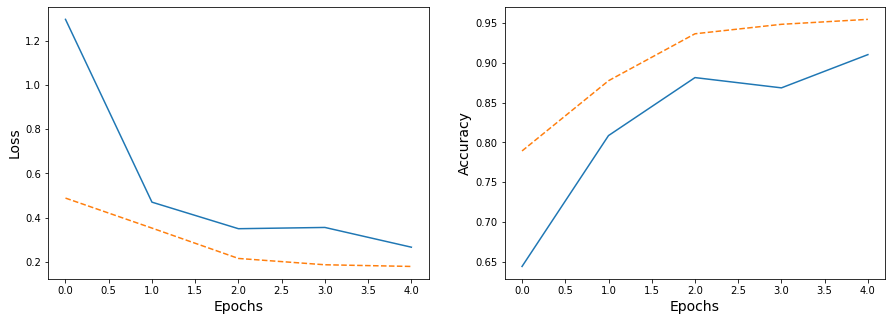

----------------------------------------------------------------------------------------
Spent time: 0:03:27.929886
Average loss error: 0.5480696737766266
Average train error: 0.8226880073547364
Average validation loss error: 0.28484503626823426
Average validation error: 0.9014879941940308
----------------------------------------------------------------------------------------


In [0]:
with tf.device('/device:GPU:0'):
    # history = model.train(iter(train_dataset), batch_count=3, epochs=10)
    history = model.train(train_dataset, epochs=5, validation_data=validation_dataset)
    # model.save(filedir=DRIVE_DIR, filename='model')

In [0]:
history = model.test(test_dataset)

196/196 [==============================] - 6s 30ms/step - loss: 0.1808 - accuracy: 0.9526


### Задание 3. Используйте индексы слов и их различное внутреннее представление (word2vec, glove). Как влияет данное преобразование на качество классификации? 

https://nlp.stanford.edu/projects/glove/

In [0]:
def load_glove_vectors():
    vectors_dict = {}
    with open(f'{DRIVE_DIR}/glove.6B.100d.txt', 'r') as f:
        for line in f.read().split('\n'):
            line_array = line.split(' ')
            vectors_dict[line_array[0]] = np.array(line_array[1:], dtype='float32')
    
    return vectors_dict

glove_vectors_dict = load_glove_vectors()

In [106]:
GLOVE_EMBEDDING_DIM = len(next(iter(glove_vectors_dict.values())))
GLOVE_EMBEDDING_DIM

100

In [128]:
def tokenize_words(dictionary, new_embedding_dim):
    embedding_matrix = np.zeros((MAX_WORDS, new_embedding_dim))
    for word, index in tokenizer.word_index.items():
        if index < MAX_WORDS:
            vector = dictionary.get(word)
            if vector is not None:
                embedding_matrix[index][:] = vector[:]
    return embedding_matrix

embedding_matrix = tokenize_words(glove_vectors_dict, GLOVE_EMBEDDING_DIM)
embedding_matrix.shape

(20000, 100)

In [0]:
# regularizer = tf.keras.regularizers.l2(0.01)

layers = [
    tf.keras.layers.Embedding(MAX_WORDS, GLOVE_EMBEDDING_DIM, input_length=MAX_PADDING_LEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
]

In [0]:
def train_model_with_glove_embedding(layers):
    model = Model(layers=layers, optimizer='adam', loss='binary_crossentropy')
    model.model.layers[0].set_weights([embedding_matrix])
    model.model.layers[0].trainable = False

    with tf.device('/device:GPU:0'):
        # history = model.train(iter(train_dataset), batch_count=3, epochs=10)
        history = model.train(train_dataset, epochs=5, validation_data=validation_dataset)
        # model.save(filedir=DRIVE_DIR, filename='model')
    return model

----------------------------------------------------------------------------------------
Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_41 (Embedding)     (None, 1000, 100)         2000000   
_________________________________________________________________
bidirectional_41 (Bidirectio (None, 128)               84480     
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 129       
Total params: 2,084,609
Trainable params: 2,084,609
Non-trainable params: 0
_________________________________________________________________
None
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
Started at 2020-04-17 15:19:53.384899
---------------------------------------------------------------

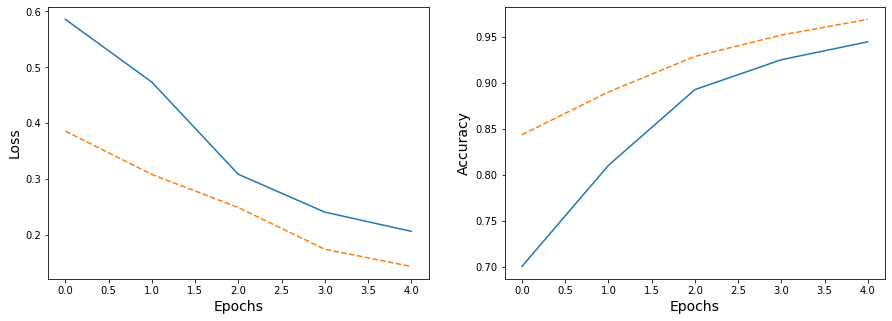

----------------------------------------------------------------------------------------
Spent time: 0:03:37.609783
Average loss error: 0.36316765248775484
Average train error: 0.8544800043106079
Average validation loss error: 0.2524115025997162
Average validation error: 0.9163840055465698
----------------------------------------------------------------------------------------


In [0]:
model = train_model_with_glove_embedding(layers)

In [0]:
model.test(test_dataset)

196/196 [==============================] - 6s 33ms/step - loss: 0.1404 - accuracy: 0.9679


[0.1404118537902832, 0.9679200053215027]

### Задание 4. Поэкспериментируйте со структурой сети (добавьте больше рекуррентных, полносвязных или сверточных слоев). Как это повлияло на качество классификации?


In [0]:

layers = [
    tf.keras.layers.Embedding(MAX_WORDS, GLOVE_EMBEDDING_DIM, input_length=MAX_PADDING_LEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
]

----------------------------------------------------------------------------------------
Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_43 (Embedding)     (None, 1000, 100)         2000000   
_________________________________________________________________
bidirectional_43 (Bidirectio (None, 128)               84480     
_________________________________________________________________
dense_56 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_57 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 129       
Total params: 2,150,529
Trainable params: 2,150,529
Non-trainable params: 0
_________________________________________________________________
None
---------------

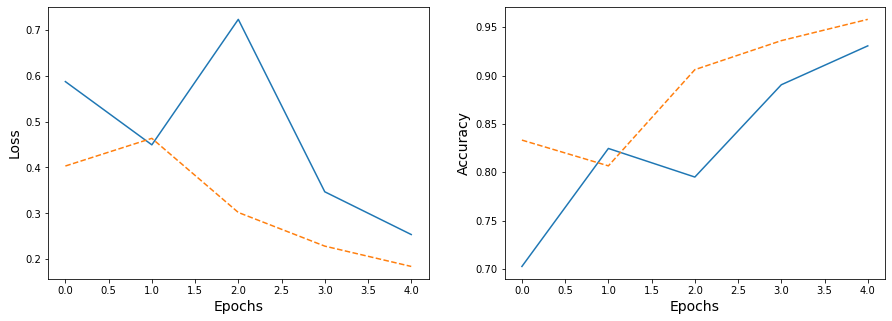

----------------------------------------------------------------------------------------
Spent time: 0:03:38.417097
Average loss error: 0.4721546769142151
Average train error: 0.828711986541748
Average validation loss error: 0.31627972722053527
Average validation error: 0.8880320072174073
----------------------------------------------------------------------------------------


In [0]:
model = train_model_with_glove_embedding(layers)

In [0]:
model.test(test_dataset)

196/196 [==============================] - 6s 33ms/step - loss: 0.2071 - accuracy: 0.9554


[0.2071375697851181, 0.9553599953651428]

### Задание 5. Используйте предобученную рекуррентную нейронную сеть (например, DeepMoji или что-то подобное).


In [21]:
!git clone https://github.com/bfelbo/DeepMoji.git
# !pip install tensorflow==1.14
import os 
os.chdir('/content/DeepMoji/deepmoji')

Cloning into 'DeepMoji'...
remote: Enumerating objects: 281, done.
remote: Total 281 (delta 0), reused 0 (delta 0), pack-reused 281
Receiving objects: 100% (281/281), 110.54 MiB | 40.50 MiB/s, done.
Resolving deltas: 100% (142/142), done.
Checking out files: 100% (66/66), done.


In [0]:
from __future__ import print_function, division
# import example_helper
import json
import csv
import numpy as np
# from deepmoji.sentence_tokenizer import SentenceTokenizer
from deepmoji.model_def import deepmoji_transfer

# from model_def import deepmoji_emojis
# from deepmoji.global_variables import PRETRAINED_PATH
from deepmoji.global_variables import PRETRAINED_PATH, VOCAB_PATH, NB_TOKENS
# from deepmoji.sentence_tokenizer import SentenceTokenizer

In [0]:
with open(VOCAB_PATH, 'r') as f:
    deepmoji_vocab = json.load(f)

In [0]:
def convert_dataset(data, old_dict, new_dict):
    inverst_dict = {v: k for k, v in old_dict.items()}
    new_data = np.zeros(data.shape)
    for i, seq in enumerate(data):
        new_data[i, :] = np.array(list(map(lambda x: new_dict.get(inverst_dict.get(x), 0), seq)))

    return new_data

In [0]:
train_data_x, train_data_y = encode_files_from('train', True)

In [0]:
deepmoji_train_data_x = convert_dataset(train_data_x, tokenizer.word_index, deepmoji_vocab)

In [0]:
test_full_data_x, test_full_data_y = encode_files_from('test', True)

In [0]:
deepmoji_test_full_data_x = convert_dataset(test_full_data_x, tokenizer.word_index, deepmoji_vocab)

In [0]:
deepmoji_validation_data_x, deepmoji_test_data_x, validation_data_y, test_data_y = train_test_split(deepmoji_test_full_data_x, test_full_data_y, test_size=0.7, random_state=42)

In [168]:
# deepmoji_base = deepmoji_emojis(nb_classes=2, maxlen=MAX_PADDING_LEN, weight_path=f'{DRIVE_DIR}deepmoji_weights.hdf5')
deepmoji_base = deepmoji_transfer(nb_classes=2,
                                  maxlen=MAX_PADDING_LEN,
                                  weight_path=f'{DRIVE_DIR}deepmoji_weights.hdf5')#,
                                #   embed_dropout_rate=0.25,
                                #   final_dropout_rate=0.5,
                                #   embed_l2=0)

# pdb.set_trace()
deepmoji_base.layers.pop()
for layer in deepmoji_base.layers[1:]:
    layer.trainable = False

x = deepmoji_base.layers[-1].output
x = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(deepmoji_base.input, outputs=x)


optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Loading weights for embedding
Loading weights for bi_lstm_0
Loading weights for bi_lstm_1
Loading weights for attlayer
Ignoring weights for softmax
Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1000, 256)    12800000    input_46[0][0]                   
__________________________________________________________________________________________________
activation_46 (Activation)      (None, 1000, 256)    0           embedding[0][0]                  
__________________________________________________________________________________________________
embed_drop (SpatialDropout1D)   (None, 100

In [169]:
with tf.device('/device:GPU:0'):
    # history = model.train(iter(train_dataset), steps_per_epoch=64, batch_count=1, epochs=1)
    # history = model.train(iter(train_dataset), steps_per_epoch=64 , epochs=5, validation_data=validation_dataset)
    history = model.fit(deepmoji_train_data_x, train_data_y, batch_size=64, epochs=15, validation_data=(deepmoji_validation_data_x, validation_data_y))

Train on 25000 samples, validate on 7500 samples
Epoch 1/15
25000/25000 [==============================] - 607s 24ms/step - loss: 0.5752 - accuracy: 0.7684 - val_loss: 0.4878 - val_accuracy: 0.8015
Epoch 2/15
25000/25000 [==============================] - 600s 24ms/step - loss: 0.4928 - accuracy: 0.7832 - val_loss: 0.4540 - val_accuracy: 0.8048
Epoch 3/15
25000/25000 [==============================] - 599s 24ms/step - loss: 0.4760 - accuracy: 0.7906 - val_loss: 0.4437 - val_accuracy: 0.8061
Epoch 4/15
25000/25000 [==============================] - 598s 24ms/step - loss: 0.4675 - accuracy: 0.7917 - val_loss: 0.4379 - val_accuracy: 0.8087
Epoch 5/15
25000/25000 [==============================] - 594s 24ms/step - loss: 0.4586 - accuracy: 0.7940 - val_loss: 0.4336 - val_accuracy: 0.8092
Epoch 6/15
25000/25000 [==============================] - 602s 24ms/step - loss: 0.4567 - accuracy: 0.7993 - val_loss: 0.4314 - val_accuracy: 0.8125
Epoch 7/15
25000/25000 [==============================] -

----------------------------------------------------------------------------------------
Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1000, 256)    12800000    input_46[0][0]                   
__________________________________________________________________________________________________
activation_46 (Activation)      (None, 1000, 256)    0           embedding[0][0]                  
__________________________________________________________________________________________________
embed_drop (SpatialDropout1D)   (None, 1000, 256)    0           activation_46[0][0]              
__

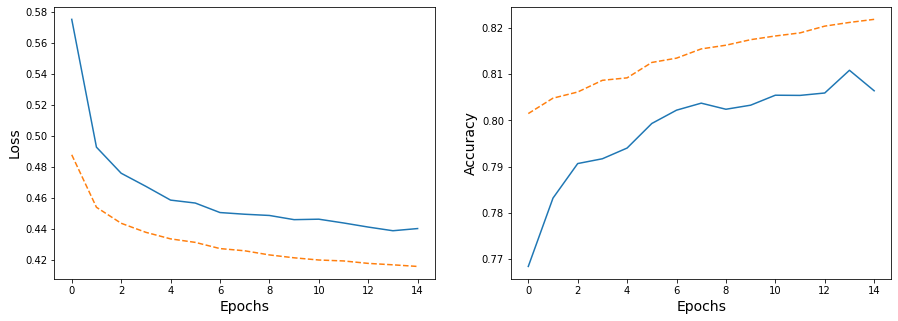

In [170]:
loss = np.array([history.history['loss']])
tran_accuracy = np.array([history.history['accuracy']])
val_loss = np.array([history.history.get('val_loss')])
val_accuracy = np.array([history.history.get('val_accuracy')])

Model(model=model)._plot_train_accuracy_graphs(loss, tran_accuracy, val_loss, val_accuracy, mode='epochs')

In [171]:
model.evaluate(deepmoji_test_data_x, test_data_y)

17500/17500 [==============================] - 609s 35ms/step


[0.40507688689231874, 0.8282285928726196]